In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx

import src
from src.reload import deep_reload

In [2]:
gdf_zones = gpd.read_file('Data/NGOD/Shapes/V2_Zones.shp')

gdf_zones['in_california'] = gdf_zones['V2ZONEID'].apply(lambda zid: 'CA' in zid)

gdf_zones_california = gdf_zones[gdf_zones['in_california']]

gdf_zones_california = gdf_zones_california.explode(drop = True)

In [17]:
atlas = src.graph.graph_from_json('Outputs/atlas_california.json')

In [5]:
filename = 'cities.json'

graph_cities = src.graph.graph_from_json(filename)

In [24]:
entity_graph = src.graph.graph_from_json('Outputs/entity_atlas_california_cities.json')

In [81]:
{k: v['time'] / 3600 for k, v in entity_graph._adj['Fresno'].items()}

{'Crescent City': 9.640270708458196,
 'Yreka': 7.160114371739356,
 'Redding': 5.707527219308463,
 'Chico': 4.464687787906536,
 'I-80 to Reno (State Line)': 4.66865771381397,
 'Sacramento': 2.8204484231046734,
 'Stockton': 2.0871465791153287,
 'San Francisco': 3.322977747946495,
 'San Jose': 2.7082465034965035,
 'Fresno': 0.0,
 'Bakersfield': 1.636722215284714,
 'Los Angeles': 3.322148976023976,
 'San Diego': 5.282255536130553,
 'I-15 to Las Vegas (State Line)': 5.855787264818521,
 'I-10 to Phoenix (State Line)': 7.148806988150745}

In [346]:
{k: v['time_nc'] / 3600 for k, v in path_values_avg.items() if 'station' not in k}

{'Fresno': 0.0,
 'Bakersfield': 1.8185802392052384,
 'Stockton': 2.3190517545725915,
 'San Jose': 3.0091627816627864,
 'Sacramento': 3.13383158122742,
 'San Francisco': 3.4114510643677307,
 'Los Angeles': 3.69127664002664,
 'Chico': 4.914709780959776,
 'I-80 to Reno (State Line)': 5.1873974597932975,
 'San Diego': 5.869172817922824,
 'Redding': 5.923978394290902,
 'I-15 to Las Vegas (State Line)': 6.5481913110038095,
 'Yreka': 7.507552709636051,
 'I-10 to Phoenix (State Line)': 7.559533367866696,
 'Crescent City': 9.728427066760407}

In [25]:
for n in entity_graph._node.values():
    
    n['distance'] = 0
    n['time'] = 0
    n['price'] = 0

for s, a in entity_graph._adj.items():
    for t, l in a.items():

        l['price'] = 0

In [70]:
deep_reload(src)

veh = src.routing.ConstrainedVehicle(
    n_cases = 1,
    risk_attitude = (0, 1),
    ess_capacity = 1e200,
    efficiency = 0,
    rate = 170e3,
    # max_soc = 10,
)

In [71]:
filename = 'cities.json'

graph_cities = src.graph.graph_from_json(filename)
origin_nodes = ['Fresno']
destination_nodes = list(graph_cities.nodes)

for n in destination_nodes:
    
    entity_graph._node[n]['min_soc'] = .5

In [73]:
deep_reload(src)

t0 = time.time()

expectations, values, paths = veh.routes(
    entity_graph,
    origins = origin_nodes,
    destinations = destination_nodes,
    return_paths = True
)

time.time() - t0

0.009471893310546875

In [75]:
pkl.dump([expectations, values, paths], open('Outputs/Gas_Fresno.pkl', 'wb'))

In [76]:
plot_graph = src.graph.subgraph(entity_graph, list(graph_cities.nodes))

paths_c = [v[1:-1] for k, v in paths.items() if k in graph_cities.nodes]
plot_graph_c = src.graph.subgraph(
    entity_graph, list(np.unique(np.concatenate(paths_c)))
)

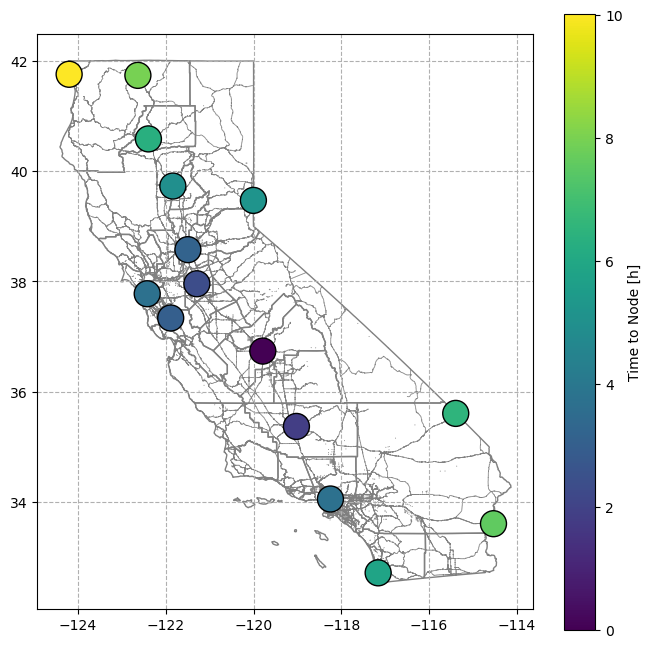

In [82]:
deep_reload(src)

path_values_avg = {}

for target, value in values.items():

    path_values_avg[target] = {}

    for key, val in value.items():

        path_values_avg[target][key] = src.routing.super_quantile(val, (0, 1))

fig, ax  = plt.subplots(figsize = (8,8))

key = 'time_nc'

for source, node in plot_graph._node.items():

		try:
			node['plot'] = path_values_avg[source][key] / 3.6e3

		except:
			node['plot'] = np.nan

gdf_zones_california.plot(ax = ax, ec = 'gray', fc = 'none')

kwargs = {
    'show_links': False,
    'node_field': 'plot',
    'scatter': {
        's': 350,
        'ec': 'k',
        'zorder': 2,
    },
    'colorbar': {
        'label': 'Time to Node [h]',
    },
    'cmap': src.figures.colormap('viridis'),
}

src.figures.plot_graph(plot_graph, ax = ax, **kwargs)

kwargs = {
		'node_field': None,
		'scatter': {
			's': .5,
			'ec': 'none',
            'fc': 'gray',
            'zorder': 0,
		},
		'show_links': False,
	}
src.figures.plot_graph(atlas, ax = ax, **kwargs)

_ = ax.grid(ls = '--')

fig.savefig('Paper/figs/R_California_Gas_Fresno.png', bbox_inches = 'tight', dpi = 300)